## Random Forest Prediction Model for Predicting Obesity
By Alka Link, Grace Pitts, Michael Carlson

In [12]:
#importing all necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.model_selection import train_test_split, RandomizedSearchCV, RepeatedStratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
from sklearn.tree import plot_tree

In [13]:
#reading in dataset
df = pd.read_csv('ObesityDataSet-1.csv')

#### Cleaning the data

In [14]:
# this is a function to combine weight categories into broader categories of Underweight, Normal, Overweight, and Obesity
#this is done by searching each row and using if statements to see which category it belongs to
def combine_weight(row):
    if row in ['Overweight_Level_I', 'Overweight_Level_II']:
        return 'Overweight'
    elif row in ['Obesity_Type_I', 'Obesity_Type_II', 'Obesity_Type_III']:
        return 'Obesity'
    elif row == 'Normal_Weight':
        return 'Normal'
    elif row == 'Insufficient_Weight':
        return 'Underweight'
    else:
        return row

#creating new column called weight and applying the combine_weight function to the NObeyesdad (target variable) column
df['weight'] = df['NObeyesdad'].apply(combine_weight)
#dropping the height and weight columns as they are not looked at in this analysis
df.drop(columns=['Weight'], inplace=True)
df.drop(columns=['Height'], inplace=True)
#dropping original target variable column
df.drop(columns=['NObeyesdad'], inplace=True)

In [15]:
#cleaning and splitting the data
def clean_split_data(df, target, train_size=0.80, tune_size=0.20, random_state=2):
    # Fill missing numeric values
    df = df.fillna(df.mean(numeric_only=True))

    # separating features and target
    X = df.drop(columns=[target])
    y = df[target]

    # Identify categorical and continuous columns
    categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
    continuous_cols = X.select_dtypes(include=['float64', 'int64']).columns.tolist()

    # Scaling continuous variables
    scaler = StandardScaler()
    X[continuous_cols] = scaler.fit_transform(X[continuous_cols])

    # One hot encode categorical variables
    dummies = pd.get_dummies(X[categorical_cols], drop_first=True)
    X = pd.concat([X.drop(columns=categorical_cols), dummies], axis=1)

    # splitting the data into training, tuning, and testing sets
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, train_size=train_size, stratify=y, random_state=random_state)
    X_tune, X_test, y_tune, y_test = train_test_split(X_temp, y_temp, train_size=tune_size, stratify=y_temp, random_state=random_state+28)

    return X_train, X_tune, X_test, y_train, y_tune, y_test

X_train, X_tune, X_test, y_train, y_tune, y_test = clean_split_data(df, 'weight')

#### Developing the model

In [16]:
#creating our kfold cross-validation object
# as well as the random forest classifier
kf = RepeatedStratifiedKFold(n_splits=10, n_repeats =5, random_state=42)
clf = RandomForestClassifier(random_state=1000, n_jobs=-1, class_weight='balanced')

In [ ]:
#creating the parameter grid, most importantly depth and number of estimators for random forest
param_grid = {
    "max_depth": [1, 5, 10, 15],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "n_estimators": [50, 100, 200, 300],
    "max_features": ['sqrt', 'log2'],
}
# setting up the randomized search cross-validation, using random seed for reproducibility
# random search is used as it is much more efficient than grid search as well as can handle larger number of estimators better
np.random.seed(1)
search = RandomizedSearchCV(
    estimator=clf,
    param_distributions=param_grid,
    scoring=['accuracy', 'recall_macro', 'balanced_accuracy', 'f1_macro'],
    cv=kf,
    n_jobs=-1,
    refit='f1_macro',
)

In [18]:
#fitting the model to the training data
model = search.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=15,
                       max_features='log2', min_samples_leaf=2, n_estimators=50,
                       n_jobs=-1, random_state=1000)


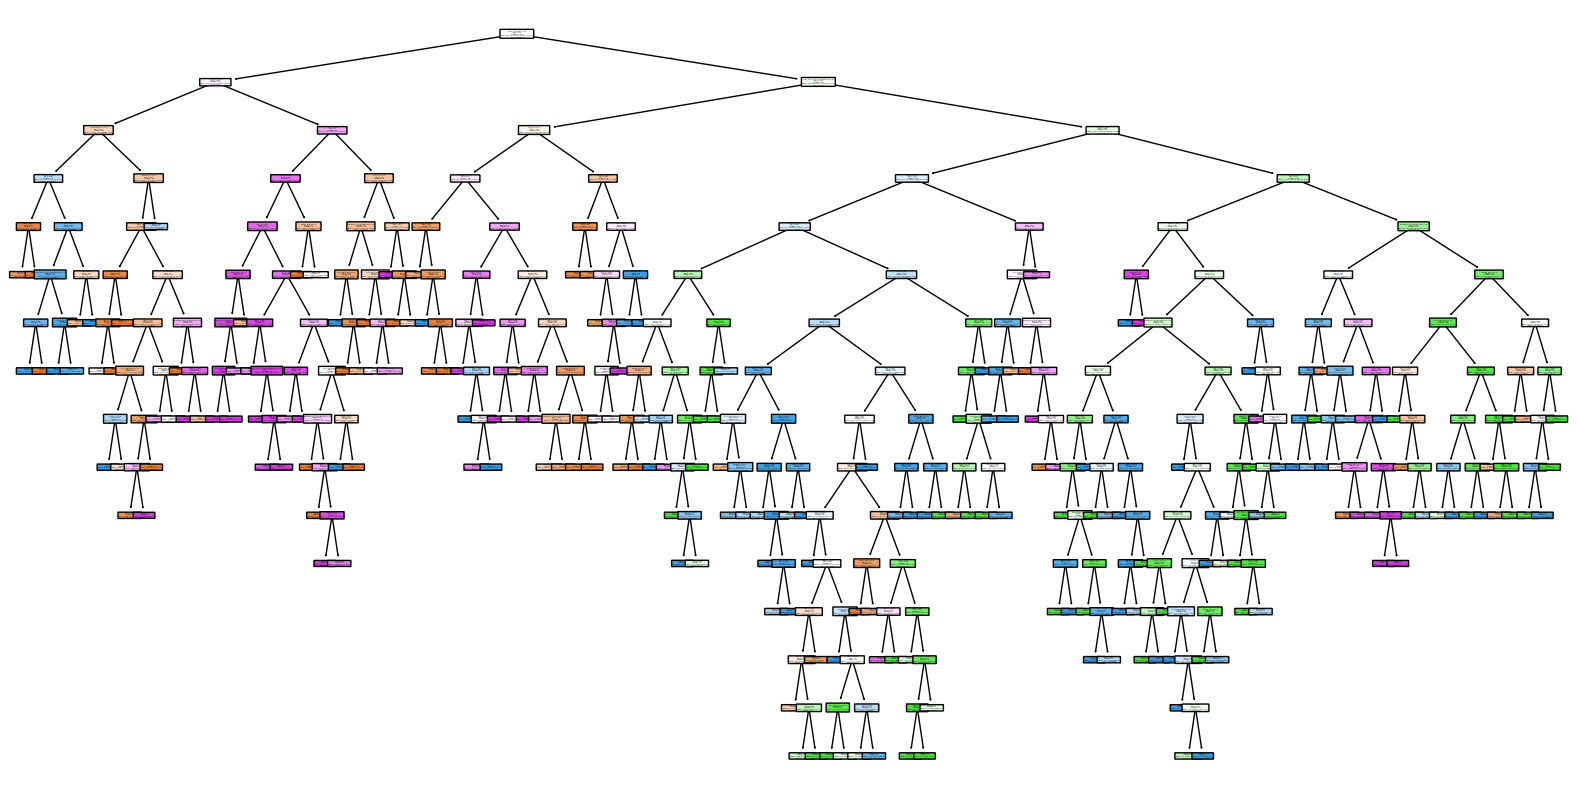

In [19]:
#printing the best model parameters
best = model.best_estimator_
print(best)
#looking at a sample of the trees
plt.figure(figsize=(20, 10))
# Visualize the first tree in the random forest
plot_tree(
	#takes first tree
	best.estimators_[0],
	feature_names=X_train.columns,
	class_names=[str(label) for label in y_train.unique()],
	filled=True,
	rounded=True
)
plt.show()

#### Evaluating model performance

In [20]:
# looking at the scoring metrics of the model
accuracy = model.cv_results_['mean_test_accuracy']
recall = model.cv_results_['mean_test_recall_macro']
bal_acc = model.cv_results_['mean_test_balanced_accuracy']
f1 = model.cv_results_['mean_test_f1_macro']

SDaccuracy = model.cv_results_['std_test_accuracy']
SDrecall = model.cv_results_['std_test_recall_macro']
SDbal_acc = model.cv_results_['std_test_balanced_accuracy']
SDf1 = model.cv_results_['std_test_f1_macro']

depth = np.unique(model.cv_results_['param_max_depth']).data

final_model = pd.DataFrame(list(zip(depth, accuracy, recall, bal_acc, f1, SDaccuracy, SDrecall, SDbal_acc, SDf1)),
               columns=['depth', 'accuracy', 'recall', 'bal_acc', 'f1', 'accuracySD', 'recallSD', 'bal_accSD', 'f1SD'])

print(final_model)

#plotting an interactive plotly express graph
fig = px.line(
    final_model,
    x='depth',
    y='f1',
    #setting error bars to deviation of f1SD
    error_y='f1SD',
    title='F1 Macro vs Depth',
    labels={'depth': 'Depth', 'f1': 'F1 Macro'},
    template='plotly_white'
)
fig.show()

   depth  accuracy    recall   bal_acc        f1  accuracySD  recallSD  \
0      1  0.854615  0.838944  0.838944  0.831377    0.026646  0.031997   
1      5  0.837786  0.827132  0.827132  0.814700    0.026820  0.028247   
2     10  0.839679  0.825655  0.825655  0.818923    0.027646  0.030731   
3     15  0.739442  0.728222  0.728222  0.719677    0.031370  0.029847   

   bal_accSD      f1SD  
0   0.031997  0.031206  
1   0.028247  0.028739  
2   0.030731  0.029481  
3   0.029847  0.031553  


                                    importance
Age                                   0.161062
CH2O                                  0.097908
NCP                                   0.097200
TUE                                   0.095312
FAF                                   0.092100
FCVC                                  0.091796
family_history_with_overweight_yes    0.073766
CAEC_Frequently                       0.058981
Gender_Male                           0.045194
CAEC_Sometimes                        0.040366
MTRANS_Public_Transportation          0.034079
CALC_no                               0.025708
FAVC_yes                              0.025311
CALC_Sometimes                        0.025063
SCC_yes                               0.010923
CALC_Frequently                       0.008026
MTRANS_Walking                        0.007479
CAEC_no                               0.006619
SMOKE_yes                             0.002879
MTRANS_Motorbike                      0.000162
MTRANS_Bike  

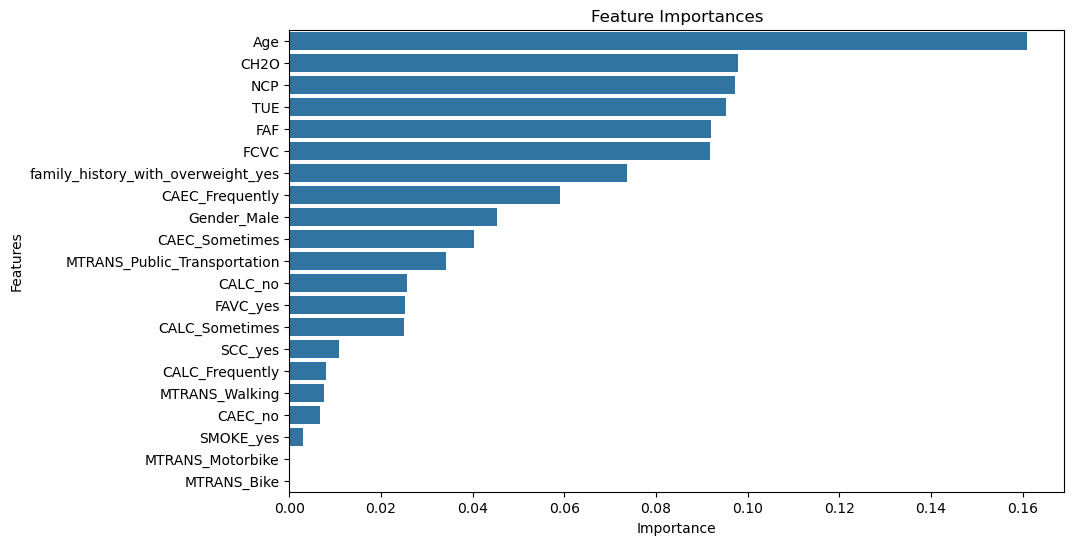

In [21]:
#looking at variable importance, and printing them in rank of importance
varimp = pd.DataFrame(best.feature_importances_, index=X_train.columns, columns=['importance']).sort_values('importance', ascending=False)
print(varimp)

# Plot the feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x=varimp['importance'], y=varimp.index)
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()

Train Set Performance:
              precision    recall  f1-score   support

      Normal       0.82      1.00      0.90       229
     Obesity       1.00      0.97      0.98       777
  Overweight       0.98      0.94      0.96       464
 Underweight       0.99      0.97      0.98       218

    accuracy                           0.96      1688
   macro avg       0.95      0.97      0.96      1688
weighted avg       0.97      0.96      0.96      1688

Tune Set Performance:
              precision    recall  f1-score   support

      Normal       0.62      0.91      0.74        11
     Obesity       0.93      0.95      0.94        39
  Overweight       0.88      0.65      0.75        23
 Underweight       1.00      1.00      1.00        11

    accuracy                           0.87        84
   macro avg       0.86      0.88      0.86        84
weighted avg       0.88      0.87      0.87        84

Test Set Performance:
              precision    recall  f1-score   support

      No

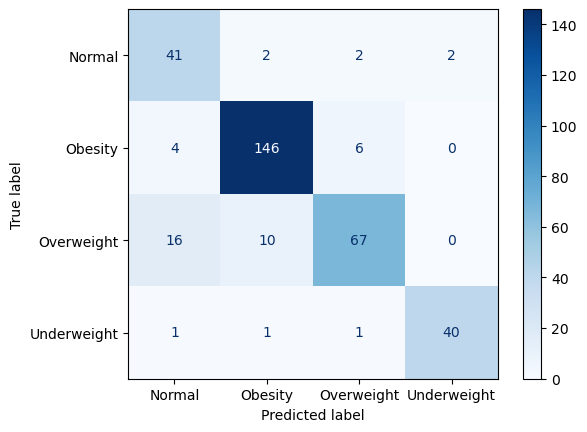

In [22]:
#looking at the accuracy of the model on the training, tuning, and testing sets
#creating predictions for each set
y_pred_train = model.predict(X_train)
y_pred_tune = model.predict(X_tune)
y_pred_test = model.predict(X_test)

#using classifaction report function to get the scoring so it is easily comparable
print("Train Set Performance:")
print(classification_report(y_train, y_pred_train))

print("Tune Set Performance:")
print(classification_report(y_tune, y_pred_tune))

print("Test Set Performance:")
print(classification_report(y_test, y_pred_test))

# Confusion Matrix of test set predictions
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test, cmap='Blues')
plt.show()